In [1]:
%matplotlib inline

from functools import reduce
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#Pandas options
pd.set_option('display.max_rows', 25)
pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:,.6f}'.format

#Set seaborn plot theme
sns.set_style('darkgrid')

# ACS Tables

In [2]:
query = """
SELECT table_id, row_count FROM `fccdsicapstone-218522.broadband.__TABLES__`
"""
tables = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')

mask = tables.table_id.str.contains('acs') & tables.row_count.between(190000, 220000)
tables[mask].sort_values('row_count', ascending=False)

,table_id,row_count
56,acs_blockgroup_pop_2014,216367
55,acs_blockgroup_2014,216367
54,acs_blockgroup2_2014,216367
51,acs_blockgroup_pop_2015,216362
52,acs_blockgroup_pop_2016,216362
47,acs_blockgroup2_2015,216362
48,acs_blockgroup2_2016,216362
49,acs_blockgroup_2015,216362
50,acs_blockgroup_2016,216362
32,acs_with_geo_2014,216330


# census_block, left join fcc and acs attributes

In [3]:
query = """
WITH block_level AS (
  SELECT 
    SUBSTR(block.block_code, 0, 12) AS block_group,
    block.total_length, 
    block.land_area, 
    block.elevation_mean,
    block.elevation_range,
    CASE WHEN fcc.block_code IS NULL THEN 0 ELSE 1 END AS int_avail,
    fcc_demography.population_2016
  FROM broadband.census_block block
  LEFT JOIN (SELECT DISTINCT block_code FROM broadband.fcc WHERE file_date = 201706) fcc
    ON block.block_code = fcc.block_code
  LEFT JOIN broadband.fcc_demography
    ON block.block_code = fcc_demography.block_code
  WHERE fcc_demography.housing_unit_2016 > 0
),
block_group_level AS ( 
  SELECT 
    block_group,
    AVG(int_avail) AS int_avail_per,
    SUM(total_length) AS total_road_length, 
    SUM(CASE WHEN int_avail = 1 THEN population_2016 ELSE 0 END) AS covered_population,
    SUM(land_area) AS total_land_area, 
    AVG(elevation_mean) AS avg_elevation,
    AVG(elevation_range) AS avg_elevation_range
  FROM block_level
  GROUP BY block_group
)

SELECT 
  block_group_level.*,
  acs_blockgroup_2016.race_total AS population,
  acs_blockgroup_2016.median_household_income_in_the_past_12_months AS income,
  acs_housing_unit.estimate_total AS housing_units,
  acs_education_average.avg_years_of_edu,
  acs_employment_percentage.unemployment_rate,
  acs_gender_age.male_ratio,
  acs_gender_age.avg_age,
  SAFE_DIVIDE(acs_blockgroup_2016.white, acs_blockgroup_2016.race_total) AS white_ratio,
  SAFE_DIVIDE(acs_blockgroup_2016.black_or_african_american, acs_blockgroup_2016.race_total) AS black_ratio,
  SAFE_DIVIDE(acs_blockgroup_2016.asian, acs_blockgroup_2016.race_total) AS asian_ratio,
  SAFE_DIVIDE(acs_blockgroup_2016.american_indian_and_alaska_native, acs_blockgroup_2016.race_total) AS native_ratio,
  SAFE_DIVIDE(acs_blockgroup_2016.hispanic_or_latino, acs_blockgroup_2016.ethnicity_total) AS hispanic_ratio
FROM block_group_level
LEFT JOIN broadband.acs_blockgroup_2016
  ON block_group_level.block_group = acs_blockgroup_2016.block_group_code
LEFT JOIN broadband.acs_housing_unit
  ON block_group_level.block_group = acs_housing_unit.block_group_code
LEFT JOIN broadband.acs_education_average
  ON block_group_level.block_group = acs_education_average.block_group_code
LEFT JOIN broadband.acs_employment_percentage
  ON block_group_level.block_group = acs_employment_percentage.block_group_code
LEFT JOIN broadband.acs_gender_age
  ON block_group_level.block_group = acs_gender_age.block_group_code
LEFT JOIN broadband.acs_hispanic
  ON block_group_level.block_group = acs_hispanic.block_group_code
"""

data = pd.read_gbq(query, project_id='fccdsicapstone-218522', dialect='standard')
data.drop_duplicates(inplace=True)

In [4]:
data.shape

(215566, 19)

### Missing values

In [5]:
data.count() / data.shape[0] * 100

block_group           100.000000
int_avail_per         100.000000
total_road_length     100.000000
covered_population    100.000000
total_land_area       100.000000
avg_elevation         100.000000
avg_elevation_range   100.000000
population             99.968455
income                 99.968455
housing_units          92.114712
avg_years_of_edu       96.274459
unemployment_rate      93.894213
male_ratio             92.077600
avg_age                92.077600
white_ratio            99.799133
black_ratio            99.799133
asian_ratio            99.799133
native_ratio           99.799133
hispanic_ratio         99.799133
dtype: float64

Text(0.5,0,'Internet availability percentage')

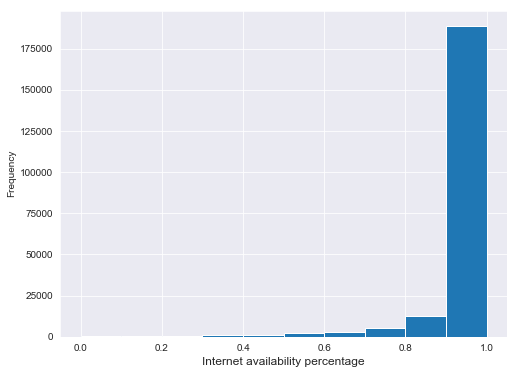

In [6]:
ax = data.int_avail_per.plot(kind='hist', figsize=(8, 6))
ax.set_xlabel('Internet availability percentage', fontsize=12)

In [7]:
data.int_avail_per.describe()

count   215,566.000000
mean          0.958990
std           0.114091
min           0.000000
25%           1.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: int_avail_per, dtype: float64

In [8]:
full_coverage = (data.int_avail_per == 1).sum() / data.shape[0] * 100
print('block_group with full coverage', 100 - full_coverage)
print('block_group without full coverage', full_coverage)

block_group with full coverage 24.538192479333475
block_group without full coverage 75.46180752066653


# Correlation Analysis

In [9]:
existing_data = data.dropna()

In [10]:
existing_data.corr()

,int_avail_per,total_road_length,covered_population,total_land_area,avg_elevation,avg_elevation_range,population,housing_units,avg_years_of_edu,unemployment_rate,male_ratio,avg_age,white_ratio,black_ratio,asian_ratio,native_ratio,hispanic_ratio
int_avail_per,1.000000,-0.334078,0.097140,-0.256647,-0.019842,-0.319198,0.015402,-0.120944,0.059657,-0.003906,-0.056776,-0.091489,-0.044414,-0.000716,0.067096,-0.083867,0.095566
total_road_length,-0.334078,1.000000,-0.005873,0.829326,0.184389,0.418187,0.002113,0.328593,-0.056442,-0.055871,0.090282,0.128658,0.168829,-0.108362,-0.124588,0.098653,-0.120635
covered_population,0.097140,-0.005873,1.000000,-0.036257,-0.017007,-0.054456,0.931807,0.303058,0.070705,-0.084927,0.002643,-0.159535,-0.014001,-0.066205,0.126729,-0.026674,0.133346
total_land_area,-0.256647,0.829326,-0.036257,1.000000,0.183124,0.382143,-0.029315,0.206770,-0.033025,-0.025815,0.061168,0.083812,0.086497,-0.064129,-0.067520,0.092364,-0.055483
avg_elevation,-0.019842,0.184389,-0.017007,0.183124,1.000000,0.251758,-0.016072,0.081547,0.043421,-0.052146,0.057956,-0.005933,0.183750,-0.180834,-0.124665,0.169229,0.014206
avg_elevation_range,-0.319198,0.418187,-0.054456,0.382143,0.251758,1.000000,-0.041997,0.184548,0.048540,-0.051359,0.074062,0.183451,0.212265,-0.158095,-0.092613,0.075491,-0.184401
population,0.015402,0.002113,0.931807,-0.029315,-0.016072,-0.041997,1.000000,0.310270,0.058325,-0.073325,0.026498,-0.231451,-0.028393,-0.051835,0.121384,-0.014748,0.128922
housing_units,-0.120944,0.328593,0.303058,0.206770,0.081547,0.184548,0.310270,1.000000,0.086156,-0.099953,0.036369,0.140534,0.177817,-0.145351,-0.050814,0.105897,-0.163803
avg_years_of_edu,0.059657,-0.056442,0.070705,-0.033025,0.043421,0.048540,0.058325,0.086156,1.000000,-0.277858,-0.040040,0.211833,0.267079,-0.199192,0.174378,-0.073406,-0.498803
unemployment_rate,-0.003906,-0.055871,-0.084927,-0.025815,-0.052146,-0.051359,-0.073325,-0.099953,-0.277858,1.000000,-0.041980,-0.121996,-0.341951,0.363024,-0.063360,0.072073,0.080320


# Linear Model

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

X = existing_data.drop(['block_group', 'int_avail_per'], axis=1)
y = existing_data['int_avail_per']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = Lasso()
model.fit(X_train, y_train)
score = model.score(X_test, y_test)
print("Score: " + str(score) + "\n")

for x, y in zip(X.columns, model.coef_):
    print (x, y)

Score: 0.1645597586447114

total_road_length -2.79916269167883e-07
covered_population 6.0784245442650754e-05
total_land_area 5.269216866357053e-11
avg_elevation 4.959021051286385e-06
avg_elevation_range -0.0
population -4.8673141964063057e-05
income 6.841065994201342e-12
housing_units -0.0
avg_years_of_edu 0.0
unemployment_rate -0.0
male_ratio -0.0
avg_age -0.0
white_ratio 0.0
black_ratio -0.0
asian_ratio 0.0
native_ratio -0.0
hispanic_ratio 0.0
